In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()

cluster.scale(10)
client = Client(cluster,timeout="120s")
cluster

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

def get_df(invar):
# this only needs to be created once
    gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
    zstore = invar.zstore.values[2]

# create a mutable-mapping-style interface to the store
    mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
    outvar = xr.open_zarr(mapper, consolidated=True)

    return outvar
import xrscipy.signal as dsp


model_names=['CanESM5','CESM2',\
             'CNRM-CM6-1','CNRM-ESM2-1','EC-Earth3','EC-Earth3-Veg','FGOALS-g3',\
                 'FIO-ESM-2-0','IPSL-CM6A-LR',\
                    'MIROC6','MIROC-ES2L', 'MPI-ESM1-2-LR','UKESM1-0-LL']


for x in range(0,len(model_names)):

    
    model_name='"'+model_names[x]+'"'
    experiment='"ssp126"'

    test='source_id == '+ model_name +' & activity_id=="CMIP" & table_id == "Omon" & variable_id == "thetao" & experiment_id == '+experiment

 #   theta = df.query('source_id =='+ model_name +' & table_id == "Amon" & variable_id == "ts" & experiment_id =='+ experiment+'& member_id == "r1i1p1f1"')
 #   tauu=df.query('source_id =='+ model_name +'& table_id == "Amon" & variable_id == "tauu" & experiment_id =='+ experiment+'& member_id == "r1i1p1f1"')
    theta = df.query('source_id =='+ model_name +' & table_id == "Amon" & variable_id == "ts" & experiment_id =='+ experiment)
    tauu=df.query('source_id =='+ model_name +'& table_id == "Amon" & variable_id == "tauu" & experiment_id =='+ experiment)


    theta_pi=get_df(theta)
    tauu_pi=get_df(tauu)
    ts_eq=theta_pi.sel(lat=slice(-5,5),lon=slice(150,280)).isel(time=slice(0,150*12))
    
    ts_eq=ts_eq.groupby('time.month')-ts_eq.groupby('time.month').mean('time')
    ts_eq=ts_eq.load()
    ts_eq=ts_eq['ts'].assign_coords(time=list(range(len(ts_eq.time))))
    ts_eq = dsp.bandpass(ts_eq,1/(7*12),1/(1.5*12),dim='time')
    
    tauu_eq=tauu_pi.sel(lat=slice(-5,5),lon=slice(120,280)).isel(time=slice(0,150*12))
    tauu_eq=tauu_eq.groupby('time.month')-tauu_eq.groupby('time.month').mean('time')
    tauu_eq=tauu_eq.assign_coords(time=list(range(len(tauu_eq.time))))
    
    tauu=tauu_eq['tauu']
    tauu=tauu.load()
    ts=ts_eq
    ts1=ts.sel(lat=slice(-5,5),lon=slice(210,280)).mean('lon').mean('lat')
    ts1.load()
    ts2=ts.sel(lat=slice(-5,5),lon=slice(150,210)).mean('lon').mean('lat')
    ts2.load()
#    import numpy.matlib

 #   ts1=np.matlib.repmat(ts1, len(tauu.lat), len(tauu.lon))
    
    
    from scipy import stats
    slope1=xr.full_like(tauu.mean('time'), np.nan, dtype=np.double)
    slope2=xr.full_like(tauu.mean('time'), np.nan, dtype=np.double)
    for i in range(0,len(tauu.lon)-1):
        for j in range(0,len(tauu.lat)-1):
            slope1[j,i], intercept, r_value, p_value, std_err = stats.linregress(ts1[:],tauu[:,j,i])
            slope2[j,i], intercept, r_value, p_value, std_err = stats.linregress(ts2,tauu[:,j,i])
           
   # noise=(tauu-((slope1*ts1)+(slope2*ts2))).mean('lat').mean('lon').std('time')
    noise=(tauu-((slope1*ts1)+(slope2*ts2)))
    noise.load()
    
    noise.to_netcdf('spatial_noise_'+model_names[x]+'_ssp126_3.nc')
    
    
    

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/srv/conda

In [27]:
x

1

0.01032168

using dimensions ('nlat', 'nlon') from data variable thetao as the horizontal dimensions for this dataset.


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:473: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [95]:

tauu=tauu_eq['tauu']
tauu=tauu.load()
ts=ts_eq['ts']
ts=ts.load()


In [96]:
from scipy import stats
slope=xr.full_like(tauu.mean('time'), np.nan, dtype=np.double)
for i in range(1,len(ts.lon)):
    for j in range(1,len(ts.lat)):
        slope[j,i], intercept, r_value, p_value, std_err = stats.linregress(ts[:,j,i],tauu[:,j,i])


In [97]:
noise=abs(tauu-(slope*ts)).sel(lon=slice(150,280)).mean('time').mean('lat').mean('lon')

In [98]:
noise.load()


<xarray.DataArray ()>
array(0.013119)

In [55]:
noise

<xarray.DataArray (time: 1032, lat: 10, lon: 129)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan, -3.26682512e-01, -3.38802925e-02, ...,
         -2.92453082e-03, -2.79327164e-03,  7.24145241e-03],
        [            nan, -1.18635044e-01, -1.37689893e-02, ...,
         -2.66420402e-03,  6.31498460e-03, -9.53183661e-04],
        ...,
        [            nan, -2.35543687e-02, -2.94979908e-02, ...,
         -1.53976975e-02, -1.52247130e-02, -1.50373490e-02],
        [            nan, -2.14327319e-02, -2.94761545e-02, ...,
         -1.65447740e-02, -1.59439189e-02, -1.40771941e-02],
        [            nan, -1.71023109e-02, -2.44385231e-02, ...,
         -1.57793391e-02, -1.53759100e-02, -1.31582110e-02]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan, -2.59376671e-01, -4.16326861e-02, ...,
         -2.03335197e-03, -1.44554804e-03,  1.60155623e-01],
        [            nan, -1.26710349e-01, -1.53818276e-02, ...,
         -2.77888965e-03, -2.14756506e-03,  4.36632777e-02],
...
        [            nan,  1.26942328e-02,  1.36947883e-02, ...,
         -5.24005206e-03, -6.11634853e-03, -6.77253085e-03],
        [            nan,  1.35690245e-02,  1.62931468e-02, ...,
         -6.67087968e-03, -7.23581029e-03, -8.01459587e-03],
        [            nan,  1.23550706e-02,  1.59344817e-02, ...,
         -7.42523121e-03, -7.89769584e-03, -8.68172754e-03]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,  8.04302490e-02,  9.82924351e-03, ...,
          7.40592079e-04,  1.46540080e-03, -6.39876771e-02],
        [            nan,  4.07708977e-02,  8.10860195e-03, ...,
         -3.56029207e-04,  2.24880273e-03, -2.27570318e-02],
        ...,
        [            nan,  8.32655413e-03,  1.05631377e-02, ...,
          6.39192465e-05,  6.04158862e-04,  3.37140192e-04],
        [            nan,  9.20668657e-03,  1.24353276e-02, ...,
          1.35674507e-03,  1.52147033e-03,  1.05207073e-03],
        [            nan,  9.99558770e-03,  1.39060671e-02, ...,
          2.31894145e-03,  1.71064510e-03,  2.06428549e-04]]])
Coordinates:
  * lat      (lat) float64 -4.241 -3.298 -2.356 -1.414 ... 2.356 3.298 4.241
  * lon      (lon) float64 120.0 121.2 122.5 123.8 ... 276.2 277.5 278.8 280.0
  * time     (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

distributed.client - ERROR - Failed to reconnect to scheduler after 120.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/

In [24]:
tauu_pi.sel(lat=slice(-5,5),lon=slice(120,280)).isel(time=slice(0,200*12)).load()

<xarray.Dataset>
Dimensions:    (lat: 10, lon: 129, nbnd: 2, time: 1032)
Coordinates:
  * lat        (lat) float64 -4.241 -3.298 -2.356 -1.414 ... 2.356 3.298 4.241
    lat_bnds   (lat, nbnd) float64 -4.712 -3.77 -3.77 -2.827 ... 3.77 3.77 4.712
  * lon        (lon) float64 120.0 121.2 122.5 123.8 ... 276.2 277.5 278.8 280.0
    lon_bnds   (lon, nbnd) float64 119.4 120.6 120.6 121.9 ... 279.4 279.4 280.6
  * time       (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
    time_bnds  (time, nbnd) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    tauu       (time, lat, lon) float32 -0.0007622 -0.0294 ... 0.01021 0.0132
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1733
    cesm_casename:          b.e21.BSSP585cmip6.f09_g17.CMIP6-SSP5-8.5.101
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2020-05-27T23:53:25Z
    data_specs_version:     01.00.31
    experiment:             SSP-based RCP scenario with high radiative forcin...
    experiment_id:          ssp585
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.s...
    grid:                   native 0.9x1.25 finite volume grid (192x288 latxlon)
    grid_label:             gn
    initialization_index:   1
    institution:            National Center for Atmospheric Research, Climate...
    institution_id:         NCAR
    license:                CMIP6 model data produced by <The National Center...
    mip_era:                CMIP6
    model_doi_url:          https://doi.org/10.5065/D67H1H0V
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   historical
    parent_mip_era:         CMIP6
    parent_source_id:       CESM2
    parent_time_units:      days since 0001-01-01 00:00:00
    parent_variant_label:   r10i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      10
    realm:                  atmos
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    source_id:              CESM2
    source_type:            AOGCM BGC AER
    status:                 2020-12-21;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/c7f821ea-34de-4d8d-878f-21ac1ece7c4f...
    variable_id:            tauu
    variant_info:           CMIP6 SSP5-8.5 experiments (2015-2100) with CAM6,...
    variant_label:          r10i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/c7f821ea-34de-4d8d-878f-21ac1ece7c4f...
    version_id:             v20200528

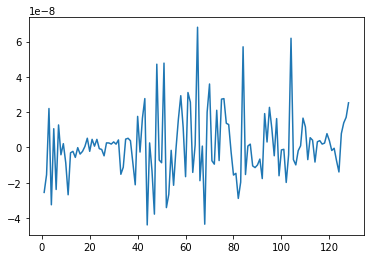

In [52]:
plt.plot(noise.mean('lat').mean('time'))